# Prototype of Phase 2

In this notebook I will prototype the whole process for phase 2. The main objective is to rank the schools based on the gap between *actual number of applicants* and *expected number of applicants*.

# Preparing the code/data

In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import expit, logit
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import r2_score

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_pickle('../data/process/schools2017.pkl')
df = df[df['# SHSAT Testers'].notnull()]  # drop schools with 0 to 5 SHSAT applicants
df.loc[df['Borough'] == 'LONG ISLAND CITY', 'Borough'] = 'Queens'  # fix Borough entry
df['% SHSAT Testers'] = df['# SHSAT Testers'] / df['# Students Grade 8']
df.head()

,School Name,Borough,Charter School,Economic Need Index,% Female,% Male,% Asian,% Black,% Hispanic,% Multiple Race Categories Not Represented,% White,% Students with Disabilities,% English Language Learners,% Poverty,Number Tested - ELA,Mean Scale Score - ELA,# Level 1 - ELA,% Level 1 - ELA,# Level 2 - ELA,% Level 2 - ELA,# Level 3 - ELA,% Level 3 - ELA,# Level 4 - ELA,% Level 4 - ELA,# Level 3+4 - ELA,% Level 3+4 - ELA,Number Tested - Math,Mean Scale Score - Math,# Level 1 - Math,% Level 1 - Math,# Level 2 - Math,% Level 2 - Math,# Level 3 - Math,% Level 3 - Math,# Level 4 - Math,% Level 4 - Math,# Level 3+4 - Math,% Level 3+4 - Math,# Students Grade 8,# SHSAT Testers,% SHSAT Testers
DBN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01M034,P.S. 034 Franklin D. Roosevelt,Manhattan,0,0.939015,0.450450,0.549550,0.033033,0.318318,0.612613,0.009009,0.027027,0.366366,0.075075,0.975976,54,298.2778,9.0,16.666670,32.0,59.25926,12.0,22.22222,1.0,1.851852,13.0,24.07407,52,285.9423,27.0,51.923080,18.0,34.61538,7.0,13.461540,0.0,0.000000,7.0,13.46154,58,6.0,0.103448
01M140,P.S. 140 Nathan Straus,Manhattan,0,0.905606,0.490566,0.509434,0.056604,0.123989,0.787062,0.005391,0.026954,0.309973,0.097035,0.873315,55,297.4545,9.0,16.363640,33.0,60.00000,12.0,21.81818,1.0,1.818182,13.0,23.63636,57,291.2456,27.0,47.368420,22.0,38.59649,8.0,14.035090,0.0,0.000000,8.0,14.03509,66,6.0,0.090909
01M184,P.S. 184m Shuang Wen,Manhattan,0,0.639987,0.498538,0.501462,0.694444,0.036550,0.134503,0.061404,0.073099,0.165205,0.150585,0.675439,81,330.1358,4.0,4.938272,17.0,20.98765,32.0,39.50617,28.0,34.567900,60.0,74.07407,83,339.6988,8.0,9.638554,14.0,16.86747,24.0,28.915660,37.0,44.578310,61.0,73.49398,87,67.0,0.770115
01M301,"Technology, Arts, and Sciences Studio",Manhattan,0,0.833962,0.452830,0.547170,0.037736,0.320755,0.547170,0.037736,0.056604,0.424528,0.028302,0.820755,41,304.7073,7.0,17.073170,19.0,46.34146,13.0,31.70732,2.0,4.878049,15.0,36.58537,41,288.1951,20.0,48.780490,15.0,36.58537,5.0,12.195120,1.0,2.439024,6.0,14.63415,51,11.0,0.215686
01M332,University Neighborhood Middle School,Manhattan,0,0.844232,0.433498,0.566502,0.088670,0.231527,0.630542,0.009852,0.039409,0.443350,0.054187,0.876847,61,296.6557,17.0,27.868850,28.0,45.90164,11.0,18.03279,5.0,8.196721,16.0,26.22951,59,281.7119,34.0,57.627120,18.0,30.50847,5.0,8.474576,2.0,3.389831,7.0,11.86441,69,13.0,0.188406


In [3]:
def identity(x):
    return x

def slugify(x):
    return '_'.join(x.lower().split())

def get_dummies(arr, baseline=None, prefix='', transform=identity):
    values = pd.unique(arr)    
    dummies = defaultdict(list)
    for item in arr:
        for value in values:
            dummies[value].append(item == value)
    
    if baseline is not None:
        del dummies[baseline]
    df = pd.DataFrame(dummies, index=getattr(arr, 'index', None))
    df = df.astype(int)  # convert booleans to int
    df = df[sorted(df.columns)]  # sort columns by name
    df.columns = [transform(c) for c in df.columns]  # transform columns names
    df.columns = [prefix + c for c in df.columns]  # add prefix to columns
    
    return df


get_dummies(df['Borough'], baseline='Manhattan', prefix='borough_', transform=slugify).head()

,borough_bronx,borough_brooklyn,borough_queens,borough_staten_island
DBN,,,,
01M034,0,0,0,0
01M140,0,0,0,0
01M184,0,0,0,0
01M301,0,0,0,0
01M332,0,0,0,0


# Creating the model

In [4]:
# for c in df.columns:
#     print("    '{}',".format(c))

columns = [
    # drop
#     'School Name',
#     '% Male',
#     '% White',
    
#     'Number Tested - ELA',
#     'Number Tested - Math',
    
#     '# Level 1 - ELA',
#     '# Level 2 - ELA',
#     '# Level 3 - ELA',
#     '# Level 4 - ELA',
#     '# Level 1 - Math',
#     '# Level 2 - Math',
#     '# Level 3 - Math',
#     '# Level 4 - Math',
    
#     '% Level 1 - ELA',
#     '% Level 1 - Math',
    
#     '# Level 3+4 - ELA',
#     '% Level 3+4 - ELA',
#     '# Level 3+4 - Math',
#     '% Level 3+4 - Math',
    
#     '# Students Grade 8',
#     '# SHSAT Testers',
#     '% SHSAT Testers',
    
    # keep
    'Charter School',
     
    '% Asian',
    '% Black',
    '% Hispanic',
    '% Multiple Race Categories Not Represented',
    
    '% Female',   
    '% Students with Disabilities',
    '% English Language Learners',
    '% Poverty',
    'Economic Need Index',
    
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math',
    
    # transform    
#     'Borough',
]

inputs = pd.concat([
    df[columns],
    get_dummies(df['Borough'], baseline='Manhattan', prefix='borough_', transform=slugify)
], axis=1)
targets = logit(df['% SHSAT Testers'])
inputs.head()

,Charter School,% Asian,% Black,% Hispanic,% Multiple Race Categories Not Represented,% Female,% Students with Disabilities,% English Language Learners,% Poverty,Economic Need Index,Mean Scale Score - ELA,% Level 2 - ELA,% Level 3 - ELA,% Level 4 - ELA,Mean Scale Score - Math,% Level 2 - Math,% Level 3 - Math,% Level 4 - Math,borough_bronx,borough_brooklyn,borough_queens,borough_staten_island
DBN,,,,,,,,,,,,,,,,,,,,,,
01M034,0,0.033033,0.318318,0.612613,0.009009,0.450450,0.366366,0.075075,0.975976,0.939015,298.2778,59.25926,22.22222,1.851852,285.9423,34.61538,13.461540,0.000000,0,0,0,0
01M140,0,0.056604,0.123989,0.787062,0.005391,0.490566,0.309973,0.097035,0.873315,0.905606,297.4545,60.00000,21.81818,1.818182,291.2456,38.59649,14.035090,0.000000,0,0,0,0
01M184,0,0.694444,0.036550,0.134503,0.061404,0.498538,0.165205,0.150585,0.675439,0.639987,330.1358,20.98765,39.50617,34.567900,339.6988,16.86747,28.915660,44.578310,0,0,0,0
01M301,0,0.037736,0.320755,0.547170,0.037736,0.452830,0.424528,0.028302,0.820755,0.833962,304.7073,46.34146,31.70732,4.878049,288.1951,36.58537,12.195120,2.439024,0,0,0,0
01M332,0,0.088670,0.231527,0.630542,0.009852,0.433498,0.443350,0.054187,0.876847,0.844232,296.6557,45.90164,18.03279,8.196721,281.7119,30.50847,8.474576,3.389831,0,0,0,0


In [5]:
model = HuberRegressor()
model.fit(inputs, targets)
predicted = model.predict(inputs)

print("R2 Score:", r2_score(targets, predicted))

R2 Score: 0.602124631330517


In [6]:
pd.Series(model.coef_, index=inputs.columns).sort_values()

% Hispanic                                   -0.069182
borough_queens                               -0.044451
borough_staten_island                        -0.023287
% Students with Disabilities                 -0.019754
Mean Scale Score - ELA                       -0.005025
Mean Scale Score - Math                      -0.003998
% English Language Learners                  -0.002749
% Female                                     -0.001892
Economic Need Index                          -0.001064
% Level 2 - Math                             -0.000124
% Poverty                                     0.001676
% Multiple Race Categories Not Represented    0.002356
% Level 3 - Math                              0.008691
% Level 2 - ELA                               0.009584
% Level 3 - ELA                               0.020566
% Level 4 - ELA                               0.025885
% Asian                                       0.027855
% Level 4 - Math                              0.029167
borough_br

# Summarizing the findings

## Residual plots (TODO)

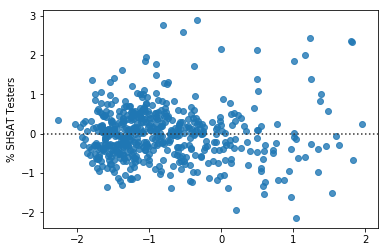

In [7]:
sns.residplot(predicted, targets);

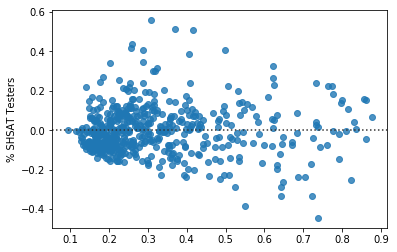

In [8]:
sns.residplot(expit(predicted), expit(targets));

## Effects in each school

In [9]:
for c in inputs.columns:
    print("    '{}',".format(c))
    
ethnicity_columns = [
    '% Asian',
    '% Black',
    '% Hispanic',
    '% Multiple Race Categories Not Represented',
]

poverty_columns = [    
    '% Poverty',
    'Economic Need Index',
]

grades_columns = [
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math',
]

borough_columns = [   
    'borough_bronx',
    'borough_brooklyn',
    'borough_queens',
    'borough_staten_island',
]

other_columns = [
    'Charter School',
    '% Female',
    '% Students with Disabilities',
    '% English Language Learners',
]  # just as a reference

    'Charter School',
    '% Asian',
    '% Black',
    '% Hispanic',
    '% Multiple Race Categories Not Represented',
    '% Female',
    '% Students with Disabilities',
    '% English Language Learners',
    '% Poverty',
    'Economic Need Index',
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math',
    'borough_bronx',
    'borough_brooklyn',
    'borough_queens',
    'borough_staten_island',


In [10]:
effects = inputs * model.coef_
effects['baseline'] = model.intercept_
effects.head()

,Charter School,% Asian,% Black,% Hispanic,% Multiple Race Categories Not Represented,% Female,% Students with Disabilities,% English Language Learners,% Poverty,Economic Need Index,Mean Scale Score - ELA,% Level 2 - ELA,% Level 3 - ELA,% Level 4 - ELA,Mean Scale Score - Math,% Level 2 - Math,% Level 3 - Math,% Level 4 - Math,borough_bronx,borough_brooklyn,borough_queens,borough_staten_island,baseline
DBN,,,,,,,,,,,,,,,,,,,,,,,
01M034,0.0,0.000920,0.020680,-0.042382,0.000021,-0.000852,-0.007237,-0.000206,0.001635,-0.000999,-1.498740,0.567911,0.457016,0.047936,-1.143067,-0.004307,0.116991,0.000000,0.0,0.0,-0.0,-0.0,-0.000766
01M140,0.0,0.001577,0.008055,-0.054451,0.000013,-0.000928,-0.006123,-0.000267,0.001463,-0.000963,-1.494603,0.575010,0.448706,0.047064,-1.164267,-0.004802,0.121976,0.000000,0.0,0.0,-0.0,-0.0,-0.000766
01M184,0.0,0.019343,0.002374,-0.009305,0.000145,-0.000943,-0.003264,-0.000414,0.001132,-0.000681,-1.658815,0.201135,0.812472,0.894799,-1.357961,-0.002099,0.251299,1.300202,0.0,0.0,-0.0,-0.0,-0.000766
01M301,0.0,0.001051,0.020838,-0.037854,0.000089,-0.000857,-0.008386,-0.000078,0.001375,-0.000887,-1.531046,0.444113,0.652083,0.126270,-1.152072,-0.004552,0.105985,0.071138,0.0,0.0,-0.0,-0.0,-0.000766
01M332,0.0,0.002470,0.015041,-0.043622,0.000023,-0.000820,-0.008758,-0.000149,0.001469,-0.000898,-1.490589,0.439898,0.370857,0.212174,-1.126155,-0.003796,0.073651,0.098870,0.0,0.0,-0.0,-0.0,-0.000766


In [11]:
# base effects
effects = inputs * model.coef_
effects['baseline'] = model.intercept_

# summarized effects
def summarize_effects(row):
    ethnicity_effect = sum(row.loc[c] for c in ethnicity_columns)
    poverty_effect = sum(row.loc[c] for c in poverty_columns)
    grades_effect = sum(row.loc[c] for c in grades_columns)
    borough_effect = sum(row.loc[c] for c in borough_columns)
    
    effects = [row['baseline'],
               ethnicity_effect, 
               poverty_effect, 
               grades_effect, 
               borough_effect,
               row['Charter School'],
               row['% Female'],
               row['% Students with Disabilities'],
               row['% English Language Learners']]
    columns_names = [
        'Baseline',
        'Ethnicity',
        'Poverty',
        'Grades',
        'Borough',
        'Charter School',
        'Female',
        'Special Education',
        'ELL',
    ]
    
    return pd.Series(effects, index=columns_names)

effects = effects.apply(summarize_effects, axis=1)
effects.head()

,Baseline,Ethnicity,Poverty,Grades,Borough,Charter School,Female,Special Education,ELL
DBN,,,,,,,,,
01M034,-0.000766,-0.020761,0.000636,-1.456259,0.0,0.0,-0.000852,-0.007237,-0.000206
01M140,-0.000766,-0.044806,0.000500,-1.470915,0.0,0.0,-0.000928,-0.006123,-0.000267
01M184,-0.000766,0.012557,0.000451,0.441034,0.0,0.0,-0.000943,-0.003264,-0.000414
01M301,-0.000766,-0.015876,0.000488,-1.288080,0.0,0.0,-0.000857,-0.008386,-0.000078
01M332,-0.000766,-0.026088,0.000571,-1.425090,0.0,0.0,-0.000820,-0.008758,-0.000149


In [12]:
effects.apply(lambda x: x ** 2).sum().sort_values()

ELL                    0.000093
Poverty                0.000155
Baseline               0.000313
Female                 0.000486
Special Education      0.010044
Charter School         0.406710
Ethnicity              0.518381
Borough                3.372269
Grades               740.609457
dtype: float64

## Percentage effects controlling for grades

In [13]:
effects2 = effects.copy()
effects2['Baseline'] = effects['Baseline'] + effects['Grades']
effects2 = effects2.drop('Grades', axis=1)

# add a catch all column
effects2['All'] = effects2.loc[:, 'Ethnicity':].sum(axis=1)

effects2.head()

,Baseline,Ethnicity,Poverty,Borough,Charter School,Female,Special Education,ELL,All
DBN,,,,,,,,,
01M034,-1.457025,-0.020761,0.000636,0.0,0.0,-0.000852,-0.007237,-0.000206,-0.028420
01M140,-1.471681,-0.044806,0.000500,0.0,0.0,-0.000928,-0.006123,-0.000267,-0.051624
01M184,0.440268,0.012557,0.000451,0.0,0.0,-0.000943,-0.003264,-0.000414,0.008388
01M301,-1.288846,-0.015876,0.000488,0.0,0.0,-0.000857,-0.008386,-0.000078,-0.024709
01M332,-1.425856,-0.026088,0.000571,0.0,0.0,-0.000820,-0.008758,-0.000149,-0.035244


In [14]:
def calculate_marginal_effect(baseline_logit, parameter_logit):
    base_pct = expit(baseline_logit)
    affected_pct = expit(baseline_logit + parameter_logit)
    
    return affected_pct - base_pct

def calculate_marginal_effects(row):
    baseline = row['Baseline']
    marginal_effs = row.iloc[1:].apply(lambda x: calculate_marginal_effect(baseline, x))
    
    return marginal_effs

marginals = effects2.apply(calculate_marginal_effects, axis=1)
marginals.sort_values('All').head()

,Ethnicity,Poverty,Borough,Charter School,Female,Special Education,ELL,All
DBN,,,,,,,,
24Q311,-0.011058,0.000120,-0.007577,0.0,-0.000165,-0.000641,-0.000113,-0.019106
24Q560,-0.007027,0.000155,-0.010896,0.0,-0.000210,-0.000748,-0.000033,-0.018808
24Q073,-0.007247,0.000098,-0.010332,0.0,-0.000201,-0.000895,-0.000093,-0.018559
30Q227,-0.006419,0.000139,-0.011111,0.0,-0.000243,-0.000710,-0.000027,-0.018366
30Q145,-0.009903,0.000126,-0.007733,0.0,-0.000157,-0.000526,-0.000105,-0.018017


In [15]:
marginals.applymap(np.abs).max().sort_values()

Poverty              0.000182
ELL                  0.000251
Female               0.000470
Special Education    0.001771
Ethnicity            0.014727
Charter School       0.015626
Borough              0.032451
All                  0.061849
dtype: float64

In [16]:
# let's consider only efects >= 1%
marginals = marginals[['Ethnicity', 'Borough', 'Charter School', 'All']]
marginals.sort_values('All').head()

,Ethnicity,Borough,Charter School,All
DBN,,,,
24Q311,-0.011058,-0.007577,0.0,-0.019106
24Q560,-0.007027,-0.010896,0.0,-0.018808
24Q073,-0.007247,-0.010332,0.0,-0.018559
30Q227,-0.006419,-0.011111,0.0,-0.018366
30Q145,-0.009903,-0.007733,0.0,-0.018017


In [17]:
abs_marginals = marginals.multiply(df['# Students Grade 8'], axis=0).applymap(np.round).astype(int)
abs_marginals.sort_values('All')

,Ethnicity,Borough,Charter School,All
DBN,,,,
24Q073,-6,-8,0,-14
24Q061,-7,-5,0,-12
24Q005,-3,-7,0,-11
30Q145,-6,-4,0,-10
24Q125,-3,-5,0,-9
27Q210,-4,-5,0,-9
30Q230,-3,-4,0,-8
30Q227,-3,-5,0,-8
24Q093,-3,-3,0,-7


## Observed gap

This is the gap between what would be expected from the grades alone, and what was actually found.

In [18]:
# logit units

expected = effects['Baseline'] + effects['Grades']
gaps = pd.DataFrame({
    'Actual': targets,
    'Expected': expected,
})
gaps['Difference'] = gaps['Actual'] - gaps['Expected']
gaps.sort_values('Difference')

,Actual,Expected,Difference
DBN,,,
02M408,-0.980829,1.036168,-2.016998
84M336,-1.661398,0.171972,-1.833369
32K554,-0.519875,0.878709,-1.398584
84M386,-0.854415,0.506950,-1.361365
09X004,-2.043074,-0.731988,-1.311086
03M291,-1.190986,0.112303,-1.303288
32K162,-2.957511,-1.659974,-1.297537
06M348,-2.602690,-1.339727,-1.262962
27Q207,-1.595049,-0.349515,-1.245534


In [19]:
# percentage units

expected = expit(effects['Baseline'] + effects['Grades'])
gaps = pd.DataFrame({
    'Actual': df['% SHSAT Testers'],
    'Expected': expected,
})
gaps['Difference'] = gaps['Actual'] - gaps['Expected']
gaps.sort_values('Difference')

,Actual,Expected,Difference
DBN,,,
02M408,0.272727,0.738110,-0.465383
84M336,0.159574,0.542887,-0.383313
32K554,0.372881,0.706555,-0.333673
84M386,0.298507,0.624091,-0.325584
03M291,0.233083,0.528046,-0.294963
84M351,0.343137,0.620879,-0.277742
02M260,0.371134,0.648749,-0.277615
27Q323,0.450216,0.712804,-0.262588
84X494,0.545455,0.805473,-0.260019


In [20]:
# absolute units

gaps_abs = gaps.multiply(df['# Students Grade 8'], axis=0)
gaps_abs = gaps_abs.applymap(np.round).astype(int)
gaps_abs.sort_values('Difference')

,Actual,Expected,Difference
DBN,,,
31R034,81,156,-75
31R007,129,195,-66
24Q061,93,154,-61
27Q323,104,165,-61
31R075,153,193,-40
03M291,31,70,-39
84M336,15,51,-36
25Q185,250,283,-33
25Q194,147,179,-32


# Effects of PASSNYC

We need to model the effects of PASSNYC, to determine where it would be most effective.

## Constant change

In this model, for each school that PASSNYC intervenes, a constant portion of the students change their ideas and apply for the test.

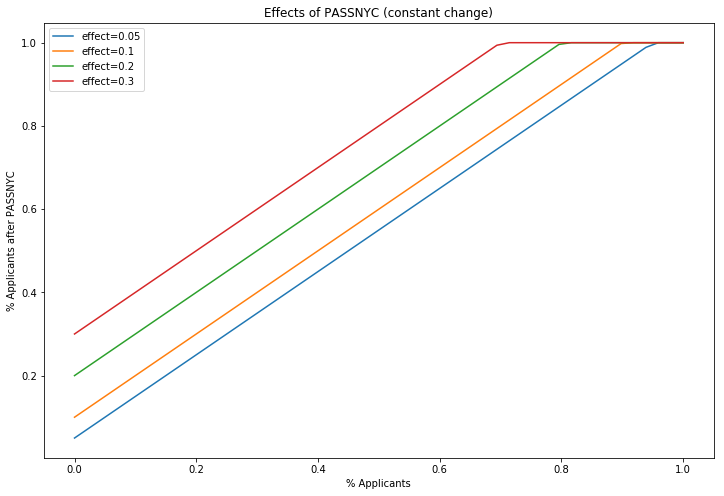

In [21]:
plt.figure(figsize=(12, 8))

for effect in [0.05, 0.1, 0.2, 0.3]:    
    initial = np.linspace(0, 1)
    affected = np.minimum(1.0, initial + effect)
    plt.plot(initial, affected, label="effect={}".format(effect))

plt.title('Effects of PASSNYC (constant change)')
plt.xlabel("% Applicants")
plt.ylabel("% Applicants after PASSNYC")
plt.legend()

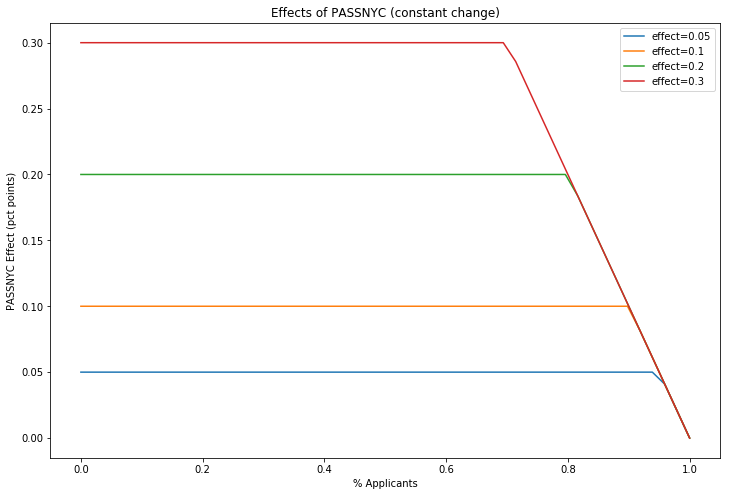

In [22]:
plt.figure(figsize=(12, 8))

for effect in [0.05, 0.1, 0.2, 0.3]:    
    initial = np.linspace(0, 1)
    affected = np.minimum(1.0, initial + effect)
    plt.plot(initial, affected - initial, label="effect={}".format(effect))

plt.title('Effects of PASSNYC (constant change)')
plt.xlabel("% Applicants")
plt.ylabel("PASSNYC Effect (pct points)")
plt.legend()

## Logit model

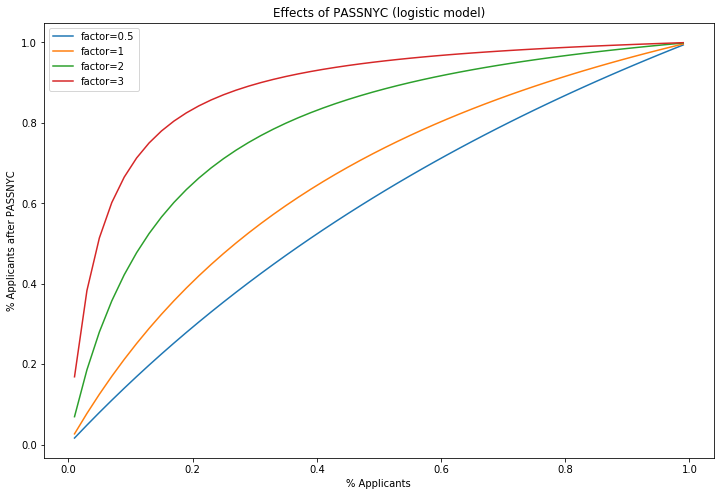

In [23]:
# an hypothesis is to give it the strength of a variable in a logit regression
# passnyc would intervene to multiply the original odds of applying by a certain amount

plt.figure(figsize=(12, 8))

for factor in [0.5, 1, 2, 3]:    
    initial = np.linspace(0.01, 0.99)
    affected = expit(logit(initial) + factor)
    plt.plot(initial, affected, label="factor={}".format(factor))

plt.title('Effects of PASSNYC (logistic model)')
plt.xlabel("% Applicants")
plt.ylabel("% Applicants after PASSNYC")
plt.legend()

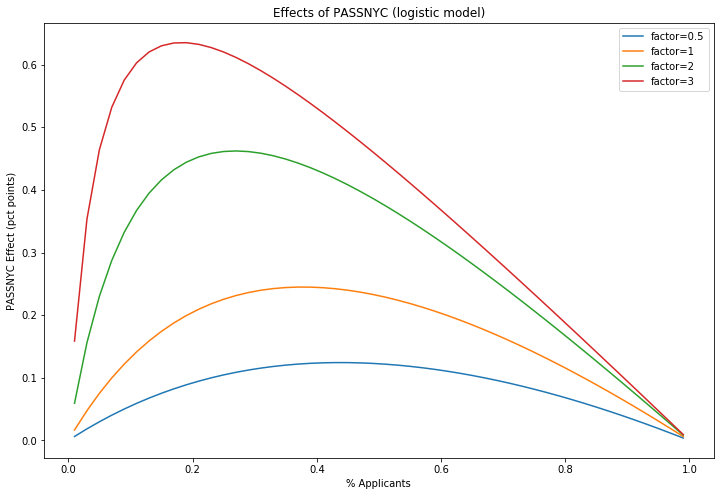

In [24]:
# an hypothesis is to give it the strength of a variable in a logit regression

plt.figure(figsize=(12, 8))

for factor in [0.5, 1, 2, 3]:    
    initial = np.linspace(0.01, 0.99)
    affected = expit(logit(initial) + factor)
    plt.plot(initial, affected - initial, label="factor={}".format(factor))

plt.title('Effects of PASSNYC (logistic model)')
plt.xlabel("% Applicants")
plt.ylabel("PASSNYC Effect (pct points)")
plt.legend()

## Brainstorming effects

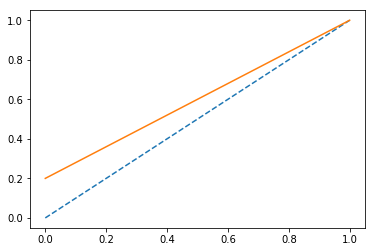

In [25]:
# linear decay over percentages

START = 0.2

xs = np.linspace(0, 1)
diffs = (1 - xs) * START
ys = xs + diffs

plt.plot(xs, xs, '--')
plt.plot(xs, ys)

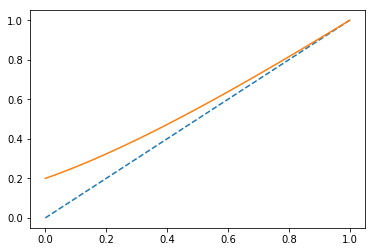

In [26]:
# exponential decay over percentages

START = 0.2
DECAY = 2
y0 = START / (1 - np.exp(-DECAY))

xs = np.linspace(0, 1)

diffs = y0 * (np.exp(-DECAY * xs) - np.exp(-DECAY))
ys = xs + diffs 

plt.plot(xs, xs, '--')
plt.plot(xs, ys)

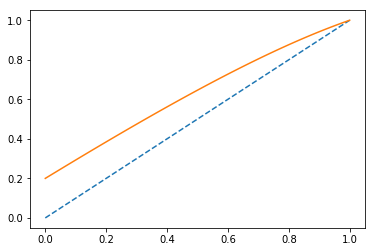

In [27]:
# reverse exponential decay over percentages (came at this by luck)

START = 0.2
DECAY = 2
y0 = START / (1 - np.exp(DECAY))

xs = np.linspace(0, 1)

diffs = y0 * (np.exp(DECAY * xs) - np.exp(DECAY))
ys = xs + diffs 

plt.plot(xs, xs, '--')
plt.plot(xs, ys)

# Maps (TODO)

After ranking and stabilishing the variables of most interest, we can plot all the schools on a map.